In [3]:
import joblib
import os
import numpy as np
import pandas as pd
import random
import json
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [6]:
import tensorflow
from tensorflow.keras.utils import Sequence #multi_gpu_model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
#from tensorflow.python.keras.optimizers import Adadelta, Nadam
from tensorflow.python.keras.models import Model, load_model
#from tensorflow.python.keras.utils import multi_gpu_model, plot_model
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping#, ReduceLROnPlateau
#from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.losses import binary_crossentropy

from tensorflow.python.keras.callbacks import Callback


In [7]:
import sys
sys.path.append('/content/drive/MyDrive/projet_9')

In [12]:
from training_azure.dilatednet_hd import DilatedNet
from training_azure.multiclassunet import Unet

In [13]:
#set parameters
batch_size = 32
optimizer = 'adam'
epoch = 150
loss = 'categorical_crossentropy'
samples = 50000
steps = samples//batch_size
img_height, img_width = 256, 256
classes = 8
filters_n = 64

#directory
working_dir = '/content/drive/MyDrive/projet_9'
image_dir = os.path.join(working_dir, 'photo')
mask_dir = os.path.join(working_dir, 'mask')
augmented_dir = os.path.join(working_dir, 'augmented')
output_dir = os.path.join(working_dir, 'training_azure/models/model_v61_aug')

#divison of labelling
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [14]:
class seg_gen(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        #make a array of length batch size containing random position of photo
        idx = np.random.randint(0, len(self.x), batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        
        for i in idx:
            #import original image /255 to normalize and avoid big number for compute power
            _image = image.img_to_array(image.load_img(self.x[i], target_size=(img_height, img_width)))/255.
            #import mask
            img = image.img_to_array(image.load_img(self.y[i], grayscale=True, target_size=(img_height, img_width)))
            #assess number of different label
            labels = np.unique(img)
            #ignore picture withtout features
            if len(labels) < 3:
                idx = np.random.randint(0, 50000, batch_size-drawn)
                continue
            img = np.squeeze(img)
            #create a tensor of dimension image with one plan for each category
            mask = np.zeros((img.shape[0], img.shape[1], 8))
            for i in range(-1, 34):
                if i in cats['void']:
                    mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
                elif i in cats['flat']:
                    mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
                elif i in cats['construction']:
                    mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
                elif i in cats['object']:
                    mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
                elif i in cats['nature']:
                    mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
                elif i in cats['sky']:
                    mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
                elif i in cats['human']:
                    mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
                elif i in cats['vehicle']:
                    mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))
            mask = np.resize(mask,(img_height*img_width, 8))
            batch_y.append(mask)
            batch_x.append(_image)
            drawn += 1
        return np.array(batch_x), np.array(batch_y)

In [15]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss

In [ ]:
image_test = []
image_test_dir = os.path.join(image_dir, 'test')
for root, dirs, files in os.walk(image_test_dir):
    for name in files:
        image_test.append(os.path.join(root, name))

mask_test = []
mask_test_dir = os.path.join(mask_dir, 'test')
for root, dirs, files in os.walk(mask_test_dir):
    for name in files:
      if '_labelIds' in name:
        mask_test.append(os.path.join(root, name))

image_test.sort()
mask_test.sort()


In [16]:
test_model = DilatedNet(256, 256, 8,use_ctx_module=True, bn=True)
test_model.load_weights(output_dir+'/dilated.h5')



. . . . .Building DilatedNet. . . . .
. . . . .Building network successful. . . . .


In [ ]:
WIDTH=256
HEIGHT=256
N_CLASSES=8

def loadImage(path):
    img = Image.open(path)
    img = np.array(img)
    
    return img

def norm_resize(image, width=WIDTH, height=HEIGHT):
    image = cv2.resize(image, (height, width))
    img = image / 255.0
    
    return img

def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=WIDTH, height=HEIGHT):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [ ]:
def display(image, truth, pred):
  fig, axs = plt.subplots(1,3, figsize=(20,20))
  image = loadImage(image)
  image = norm_resize(image)
  axs[0].imshow(image)
  axs[0].set_title('Image')

  truth = loadImage(truth)
  truth = get_cat(truth)
  truth = give_color_to_seg_img(truth)
  axs[1].imshow(truth)
  axs[1].set_title('Ground truth')

  pred = np.squeeze(pred)
  pred = pred.reshape(256, 256, 8)
  pred = cv2.resize(pred, (256, 256))
  pred = np.argmax(pred, axis=2)
  axs[2].imshow(pred)
  axs[2].set_title('Prediction')
  plt.show()

In [ ]:
def get_cat(mask_input, width=WIDTH, height=HEIGHT):
  ''' Function that take a array mask of dimension (1024 2048)
    with 36 label and return a mask of dimension Height width with 8 labels'''
    
  img = mask_input
  mask = np.zeros((img.shape[0], img.shape[1], 8))
  for i in range(-1, 34):
      if i in cats['void']:
          mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
      elif i in cats['flat']:
          mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
      elif i in cats['construction']:
          mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
      elif i in cats['object']:
          mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
      elif i in cats['nature']:
          mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
      elif i in cats['sky']:
          mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
      elif i in cats['human']:
          mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
      elif i in cats['vehicle']:
          mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i)) 
  mask = cv2.resize(mask, (height, width))
  mask = np.argmax(mask, axis=-1)
  return mask

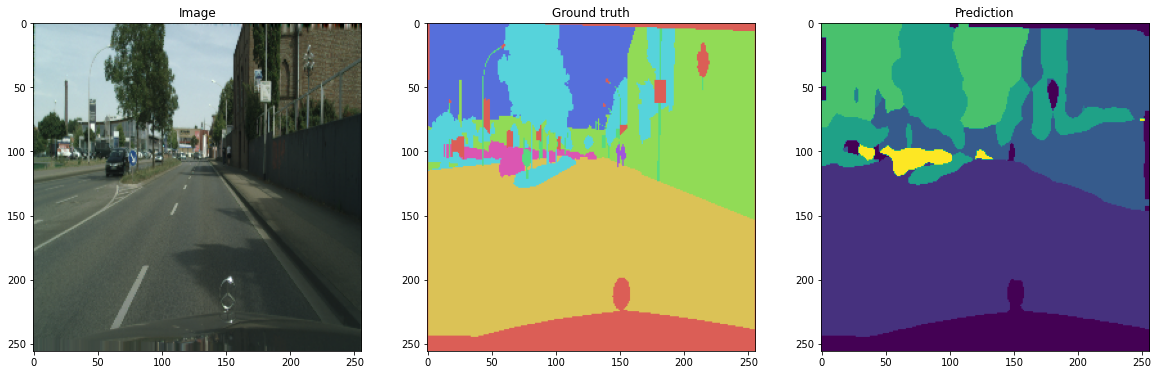

In [ ]:
img = loadImage(image_test[3])
img = norm_resize(img)
z = test_model.predict(np.expand_dims(img, axis=0))
display(image_test[3], mask_test[3], z)

In [17]:
test_model.summary()

Model: "DilatedNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1728      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 256, 256, 64)     256       
 ion)                                                            
                                                                 
 block1_relu1 (Activation)   (None, 256, 256, 64)      0         
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36864     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 256, 256, 64)     256       
 ion)                                                   

In [ ]:
img = loadImage(image_test[2])
img = norm_resize(img)
z = test_model.predict(np.expand_dims(img, axis=0))

NameError: ignored

In [ ]:
z = np.squeeze(z)
z = z.reshape(256, 256, 8)
z = cv2.resize(z, (256, 256))
y = np.argmax(z, axis=2)

In [ ]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
test_model.compile(optimizer=optimizer, loss=loss, metrics=[dice_coeff, 'accuracy'])
test_eval = test_model.evaluate(test_gen)

In [ ]:
img = image.img_to_array(image.load_img(image_test[i]))/255 


In [ ]:
i = 100
img = image.img_to_array(image.load_img(image_test[i]))/255    
dims = img.shape
x = cv2.resize(img, (256, 256))
x = np.float32(x)/255.
p = test_model.predict(np.expand_dims(x, axis=0))

In [ ]:
z

array([[[4.02101427e-01, 1.04855666e-04, 5.95626295e-01, ...,
         1.13333634e-04, 4.68838834e-07, 2.02603801e-03],
        [4.02101427e-01, 1.04855666e-04, 5.95626295e-01, ...,
         1.13333634e-04, 4.68838834e-07, 2.02603801e-03],
        [4.02101427e-01, 1.04855666e-04, 5.95626295e-01, ...,
         1.13333634e-04, 4.68838834e-07, 2.02603801e-03],
        ...,
        [8.51414800e-01, 7.21859634e-02, 8.29483732e-04, ...,
         4.61603253e-04, 4.28627245e-05, 6.54504448e-02],
        [8.51414800e-01, 7.21859634e-02, 8.29483732e-04, ...,
         4.61603253e-04, 4.28627245e-05, 6.54504448e-02],
        [8.51414800e-01, 7.21859634e-02, 8.29483732e-04, ...,
         4.61603253e-04, 4.28627245e-05, 6.54504448e-02]]], dtype=float32)

In [ ]:
p

array([[[4.1075698e-01, 8.8220426e-05, 5.8632004e-01, ...,
         1.3204031e-04, 7.2124567e-07, 2.6777068e-03],
        [4.1075698e-01, 8.8220426e-05, 5.8632004e-01, ...,
         1.3204031e-04, 7.2124567e-07, 2.6777068e-03],
        [4.1075698e-01, 8.8220426e-05, 5.8632004e-01, ...,
         1.3204031e-04, 7.2124567e-07, 2.6777068e-03],
        ...,
        [8.7145376e-01, 6.9938846e-02, 7.5160014e-04, ...,
         3.9257793e-04, 4.7919006e-05, 4.9652729e-02],
        [8.7145376e-01, 6.9938846e-02, 7.5160014e-04, ...,
         3.9257793e-04, 4.7919006e-05, 4.9652729e-02],
        [8.7145376e-01, 6.9938846e-02, 7.5160014e-04, ...,
         3.9257793e-04, 4.7919006e-05, 4.9652729e-02]]], dtype=float32)

In [ ]:
z1 = np.squeeze(z)
z1

array([[4.02101427e-01, 1.04855666e-04, 5.95626295e-01, ...,
        1.13333634e-04, 4.68838834e-07, 2.02603801e-03],
       [4.02101427e-01, 1.04855666e-04, 5.95626295e-01, ...,
        1.13333634e-04, 4.68838834e-07, 2.02603801e-03],
       [4.02101427e-01, 1.04855666e-04, 5.95626295e-01, ...,
        1.13333634e-04, 4.68838834e-07, 2.02603801e-03],
       ...,
       [8.51414800e-01, 7.21859634e-02, 8.29483732e-04, ...,
        4.61603253e-04, 4.28627245e-05, 6.54504448e-02],
       [8.51414800e-01, 7.21859634e-02, 8.29483732e-04, ...,
        4.61603253e-04, 4.28627245e-05, 6.54504448e-02],
       [8.51414800e-01, 7.21859634e-02, 8.29483732e-04, ...,
        4.61603253e-04, 4.28627245e-05, 6.54504448e-02]], dtype=float32)

In [ ]:
z = z.reshape(256, 256, 8)
z = cv2.resize(z, (dims[1], dims[0]))
y = np.argmax(z, axis=2)
y

array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
p.shape

(1, 65536, 8)

In [ ]:
ps = p.reshape(256, 256, 8)

In [ ]:
psp = cv2.resize(ps, (dims[1], dims[0]))

In [ ]:
psp.shape

(1024, 2048, 8)